# **Anomaly detection using LSTM**

## **Long Short Term Memory**


In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/jyotie02/TimeSeries/refs/heads/main/ambient_temperature_system_failure.txt")

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [6]:
print(df.head(10))

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551
5  2013-07-04 05:00:00  70.060966
6  2013-07-04 06:00:00  69.279765
7  2013-07-04 07:00:00  69.369608
8  2013-07-04 08:00:00  69.166714
9  2013-07-04 09:00:00  68.986083


<Axes: xlabel='timestamp'>

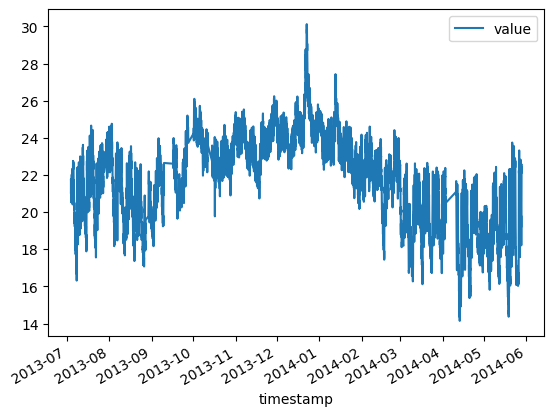

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

# Extract useful features

Extracting the following useful features :

**1. Hours** - 24 hours (0-23) \

**2. Daytime** - \
 Daytime = 1 , if hour is in 7:00 AM to 10:00 PM \
 Daytime = 0 , otherwise (Night_time) \

**3. DayOfTheWeek** -  ( Monday - 0 )  to (Sunday - 6) \

**4. WeekDay** - \
WeekDay = 1 , if Day of week < 5 \
WeekDay = 0 , Otherwise (saturday and sunday)

**5. categories** - \
0 - Week end night \
1 - Week end daytime \
2 - Week day night \
3 - Week day day time \


In [8]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [10]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [11]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

In [12]:
df.to_csv("data1.csv",index=None)

# Long Short term memory (LSTM) model -1

 - Anomaly detection using time series forecasting

**# Read the data**

In [13]:
df = pd.read_csv("data1.csv")

In [14]:
df.head()

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2


**# Standardize data**

Standardize features by removing the mean and scaling to unit variance. \

In [15]:
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay','categories']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [16]:
data_n.head(5)

,0,1,2,3,4,5
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132,-0.108248
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132,-0.108248
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132,-0.108248
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132,-0.108248
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132,-0.108248


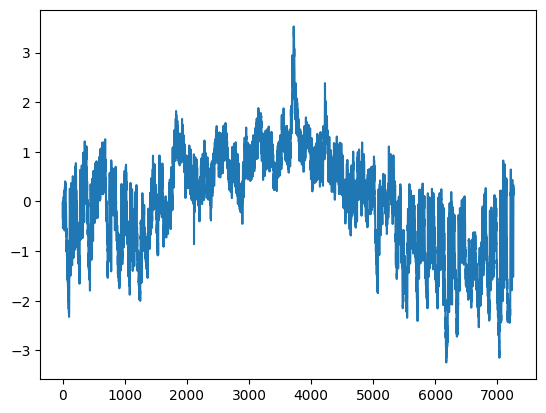

In [17]:
plt.plot(data_n[0])

**Time Series Lag Scatter Plots**

 - Time series modeling assumes a relationship between an observation and the previous observation.

 - If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.

 - If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.


**Example -**

**Series** \
 {1,2,3,4,5,6,7,8,9}

**Lagged version of series** \
 {1,2,3,4,5,6,7,8} \
 {2,3,4,5,6,7,8,9}

<Axes: xlabel='y(t)', ylabel='y(t + 2)'>

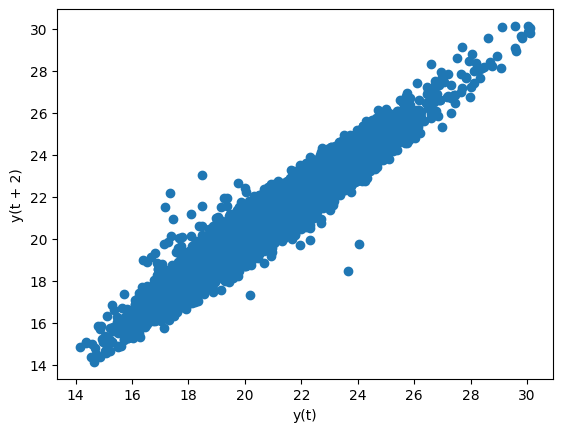

In [18]:
pd.plotting.lag_plot(df['value'], lag=2)

# Prepare data set for time series forecasting

**# split the data set into train and test set** \

Train set - (input_train, output_train) \
test set - (input_test, output_test)  \

**# dataset**

In [19]:
data_n.shape

(7267, 6)

In [20]:
data_n.head()

,0,1,2,3,4,5
0,-0.320586,-1.661537,-1.414798,0.005769,0.62132,-0.108248
1,-0.005228,-1.517172,-1.414798,0.005769,0.62132,-0.108248
2,-0.085851,-1.372807,-1.414798,0.005769,0.62132,-0.108248
3,-0.537536,-1.228442,-1.414798,0.005769,0.62132,-0.108248
4,-0.461215,-1.084077,-1.414798,0.005769,0.62132,-0.108248


In [21]:
# important parameters
prediction_time = 1
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values

# test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [22]:
print(x_train[0])
print(x_train[1])
print(x_train[2])
print(x_train[3])
print(x_train[4])

[-0.32058581 -1.66153683 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.00522828 -1.51717197 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.08585098 -1.37280711 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.53753615 -1.22844225 -1.41479759  0.00576899  0.62131999 -0.10824848]
[-0.46121534 -1.08407739 -1.41479759  0.00576899  0.62131999 -0.10824848]


In [23]:
print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

-0.005228281827377506
-0.08585097833639213
-0.537536152011907
-0.4612153358440536
-0.27817435608313573


**# size of train and test data set**

In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6215, 6)
y_train (6215,)
x_test (1050, 6)
y_test (1050,)


In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6215, 6)
(6215,)
(1050, 6)
(1050,)


**# windowing**

Window size = 50

**# shape of data**

In [26]:
#windowing
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 6)
y_train (6165,)
x_test (1000, 50, 6)
y_test (1000,)


# LSTM model -1




In [32]:
model1 = Sequential()
model1.add(LSTM(30,input_shape=(50, 6),return_sequences=True))
model1.add(Dropout(0.5))
model1.add(LSTM(30,return_sequences=False))
model1.add(Dropout(0.5))
model1.add(Dense(units=1))
model1.add(Activation('linear'))
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 30)         │         4,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         7,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,791 (46.06 KB)

 Trainable params: 11,791 (46.06 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
x_train.shape

(6165, 50, 6)

**# compile the model**

In [34]:
start = time.time()
model1.compile(loss='mse', optimizer='adam')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.013876676559448242


**# Train the model**

In [35]:
model1.fit(
    x_train,
    y_train,
    batch_size=3000,
    epochs=20,
    validation_split=0.1)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.9460 - val_loss: 1.5552
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.8292 - val_loss: 1.4920
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 741ms/step - loss: 0.7416 - val_loss: 1.4297
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 743ms/step - loss: 0.6512 - val_loss: 1.3679
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - loss: 0.5770 - val_loss: 1.3050
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step - loss: 0.5172 - val_loss: 1.2373
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - loss: 0.4602 - val_loss: 1.1573
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.4189 - val_loss: 1.0612
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step - loss: 0.3731 - val_loss: 0.9523
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 748ms/step - loss: 0.3380 - val_loss: 0.8385
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - loss: 0.3005 - val_loss: 0.7284
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step - loss: 0.2706 - val_loss: 0.627

# Predict model on train and test data

 **- Difference between prediction and test data**

In [36]:
loaded_model = model1
diff=[]
p = loaded_model.predict(x_test)
q = loaded_model.predict(x_train)
for u in range(len(y_test)):
    pr = p[u][0]
    diff.append(abs(y_test[u]- pr))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


**# Plot the prediction and the reality (for the test data)**

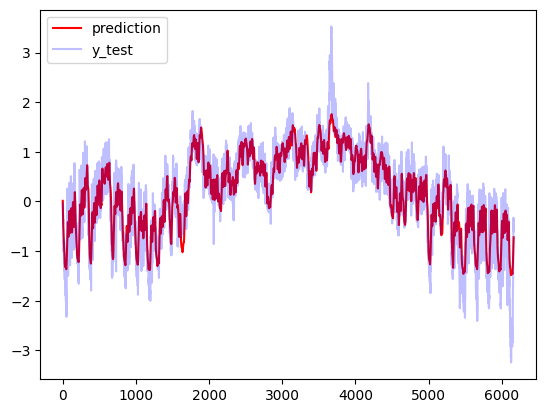

In [37]:
 #plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(q,color='red', label='prediction')
axs.plot(y_train,color='blue',alpha = 0.25, label='y_test')
plt.legend(loc='upper left')
plt.show()

In [38]:
#Pick the most distant prediction/reality data points as anomalies
outlier=0.1
diff = pd.Series(diff)
number_of_outliers = int(outlier*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
pred=pd.DataFrame({'B' : test,'C' : y_test,'A': df.iloc[-1001:-1,6:7].values.flatten()})
#pred.append(test, ignore_index='True')

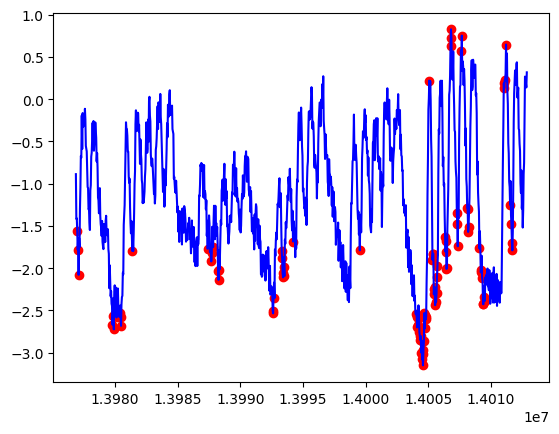

In [39]:
fig, ax = plt.subplots()

a = pred.loc[pred['B'] == 1, ['A', 'C']] #anomaly

ax.plot(pred['A'], pred['C'], color='blue')
ax.scatter(a['A'],a['C'], color='red')
plt.show()

# LSTM model - 2

In [40]:
model2 = Sequential()
model2.add(LSTM(128,input_shape=(50, 6),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128,return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(units=1))
model2.add(Activation('linear'))
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,833 (784.50 KB)

 Trainable params: 200,833 (784.50 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
start = time.time()
model2.compile(loss='mse', optimizer='adam')

In [42]:
model2.fit(
    x_train,
    y_train,
    batch_size=3000,
    epochs=20,
    validation_split=0.1)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step - loss: 0.6779 - val_loss: 0.7031
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 0.2803 - val_loss: 0.3808
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - loss: 0.1681 - val_loss: 0.2522
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 0.1461 - val_loss: 0.1996
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0965 - val_loss: 0.1747
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.1114 - val_loss: 0.1508
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 0.1081 - val_loss: 0.1404
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - loss: 0.0903 - val_loss: 0.1380
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.0786 - val_loss: 0.1362
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - loss: 0.0828 - val_loss: 0.1320
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 0.0802 - val_loss: 0.1395
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 0.0725 - val_loss: 0.1565
Epoch 13/20
2/

In [43]:
loaded_model = model2
diff=[]
p = loaded_model.predict(x_test)
q = loaded_model.predict(x_train)
for u in range(len(y_test)):
    pr = p[u][0]
    diff.append(abs(y_test[u]- pr))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step


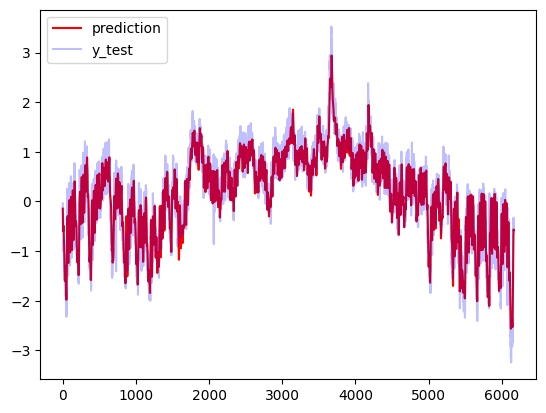

In [44]:
 #plot the prediction and the reality (for the test data)
fig, axs = plt.subplots()
axs.plot(q,color='red', label='prediction')
axs.plot(y_train,color='blue',alpha = 0.25, label='y_test')
plt.legend(loc='upper left')
plt.show()

In [45]:
#Pick the most distant prediction/reality data points as anomalies
outlier=0.1
diff = pd.Series(diff)
number_of_outliers = int(outlier*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
pred=pd.DataFrame({'B' : test,'C' : y_test,'A': df.iloc[-1001:-1,6:7].values.flatten()})
#pred.append(test, ignore_index='True')

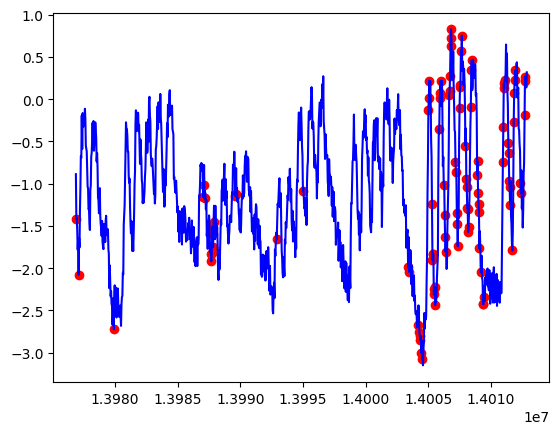

In [46]:
fig, ax = plt.subplots()

a = pred.loc[pred['B'] == 1, ['A', 'C']] #anomaly

ax.plot(pred['A'], pred['C'], color='blue')
ax.scatter(a['A'],a['C'], color='red')
plt.show()